# Oszillograph

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter

plt.style.use('science')

In [3]:
def get_all_csv() -> list[str]:
    files = sorted([i for i in os.listdir(os.getcwd() + '/data') if i[-4:] == '.csv'])
    if not files:
        print(f"Keine .csv Dateien gefunden.")
        return []

    return list(files)

def extract_csv(filepath:str, skipheader:int=12, use_mask:bool=False)->tuple:
    with open(f'data/{filepath}', 'r', errors='ignore') as f:
        lines = f.readlines()

    channels = lines[10].split(',')[1:]
    units = lines[11].split(',')
    if len(channels) not in [1, 2]:
        return False

    try:
        data = np.genfromtxt(f'data/{filepath}', delimiter=',', skip_header=skipheader)
    except Exception as e:
        print(f"[ERROR] Datei {os.path.basename(filepath)}: Fehler beim Einlesen: {e}")
        return False
    
    time = data[: , 0]
    ch = []
    for j in range(len(channels)):
        ch.append(data[:, j+1])
    return time, ch, units

In [4]:
AXES = {
    2 : (0, 0),
    3 : (0, 1),
    4 : (1, 0)
}
files = get_all_csv()

## Versuch 1 Tiefpass

### Sinus

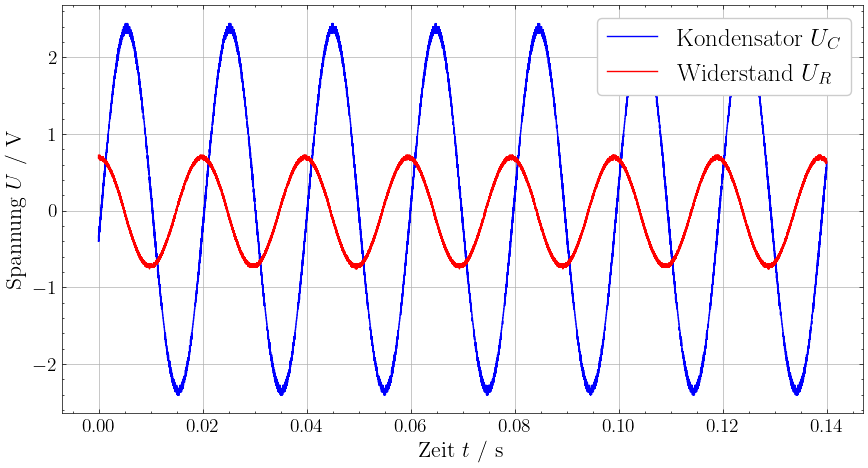

In [8]:
plt.rcParams.update({'font.size': 14})
l = [r'Kondensator $U_C$', r'Widerstand $U_R$']

plt.figure(figsize=(9, 5))
time, channels, units = extract_csv(files[0])
color = ['blue', 'red']
for j in range(len(channels)):
    plt.plot(time, channels[j], label=l[j], color=color[j])
plt.xlabel(r'Zeit $t$ / s', fontsize=16)
plt.ylabel(r'Spannung $U$ / V', fontsize=16)
plt.legend(loc='best',framealpha=1, facecolor='white',frameon=True, fontsize=18)
plt.grid(True)
plt.tight_layout()

#### Periodendauer

Detected 7 peaks, giving 6 periods.
Mean period = 0.019809 s
Std (sample) = 0.000099 s


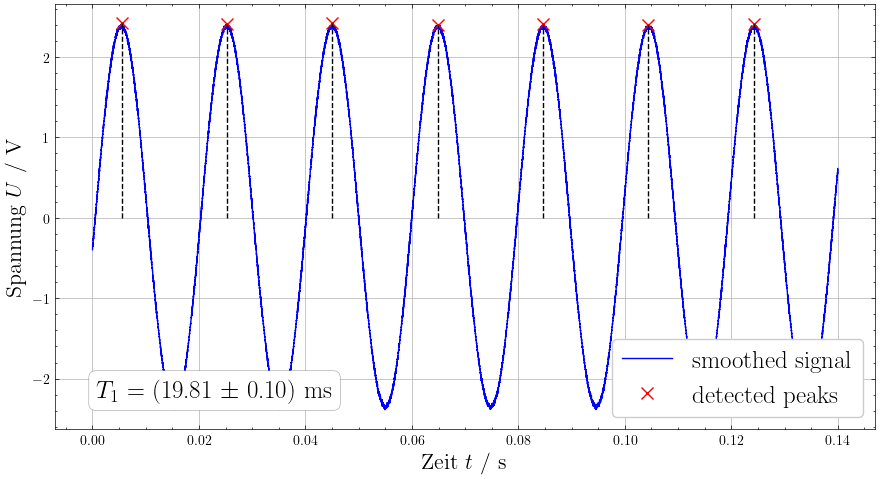

In [5]:
time, channels, units = extract_csv(files[0])
t = time
y = channels[0]

USE_SMOOTHING = True
if USE_SMOOTHING:
    # window_length must be odd and <= len(y); adjust if necessary
    wl = 11 if len(y) >= 11 else (len(y) // 2 * 2 + 1)
    if wl >= 3:
        y_smooth = savgol_filter(y, window_length=wl, polyorder=3)
    else:
        y_smooth = y.copy()
else:
    y_smooth = y.copy()


# find peaks and clculate Period
peaks, props = find_peaks(y_smooth, prominence=0.07, distance=200)
peak_times = t[peaks]
periods = np.diff(peak_times) 

if len(periods) == 0:
    print("No periods found: adjust peak detection parameters (prominence/distance/threshold) or smoothing.")
else:
    mean_period = np.mean(periods)
    std_period = np.std(periods, ddof=1)
   
    print(f"Detected {len(peaks)} peaks, giving {len(periods)} periods.")
    print(f"Mean period = {mean_period:.6f} s")
    print(f"Std (sample) = {std_period:.6f} s")

    # --- plots ---
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    # ax.plot(t, y, label='raw signal')
    if USE_SMOOTHING:
        ax.plot(t, y_smooth, label='smoothed signal', linewidth=1, color='blue')
    ax.plot(peak_times, (y_smooth[peaks]), 'x', markersize=8, label='detected peaks', color='red')
    ax.vlines(peak_times, 0, (y_smooth[peaks]), color='black', linestyles='--')
    ax.set_xlabel(r'Zeit $t$ / s', fontsize=16)
    ax.set_ylabel(r'Spannung $U$ / V', fontsize=16)
    ax.grid(True)
    ax.legend(loc='lower right', frameon=True, fontsize=18, framealpha=1)

    # annotate mean period on plot
    if len(periods) > 0:
        ax.annotate(rf"$T_1$ = ({mean_period*1000:.2f} $\pm$ {std_period*1000:.2f}) ms",
                     xy=(0.05, 0.12), xycoords='axes fraction', va='top', fontsize=18,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=(0, 0, 0, 0.3), lw=0.5))
    
    plt.tight_layout()

In [21]:
mean_period = np.mean(periods) * 1000
std_period = np.std(periods, ddof=1) * 1000
print(mean_period)
mean_t = 4.4 
std_t = 0.4

phi = 360*mean_t/mean_period
dphi = phi*(std_t/mean_t + std_period/mean_period)

print(phi, dphi)

19.809333333333335
79.96230732987817 7.668925187568879


### Rechteck

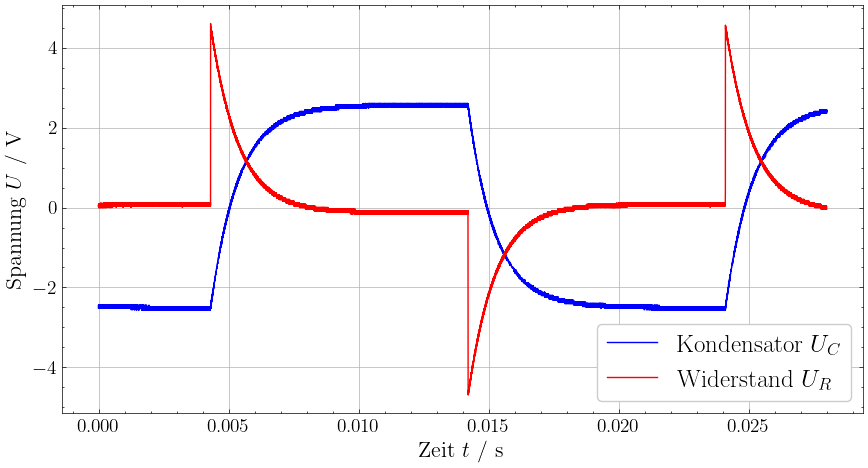

In [22]:
plt.rcParams.update({'font.size': 14})
l = [r'Kondensator $U_C$', r'Widerstand $U_R$']

plt.figure(figsize=(9, 5))
time, channels, units = extract_csv(files[1])
color = ['blue', 'red']
for j in range(len(channels)):
    plt.plot(time, channels[j], label=l[j], color=color[j])
plt.xlabel(r'Zeit $t$ / s', fontsize=16)
plt.ylabel(r'Spannung $U$ / V', fontsize=16)
plt.legend(loc='lower right',framealpha=1, facecolor='white',frameon=True, fontsize=18)
plt.grid(True)
plt.tight_layout()

#### Rechteck Fit

In [38]:
def fit_func(t, A0, lam):
    return A0 * np.exp(-t*lam)

def fit_func2(t, A0, lam):
    return (1 - A0 * np.exp(-t*lam))

0.951165329565408 0.0010811570314794082


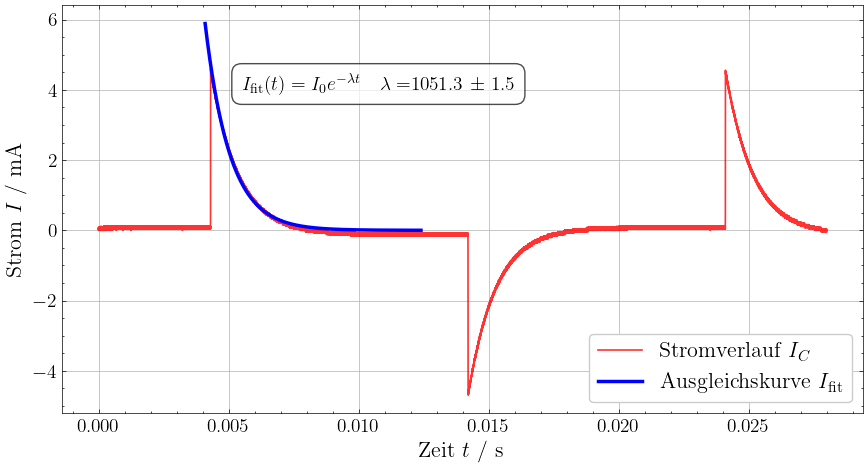

In [43]:
time, channels, units = extract_csv(files[1])
mask = np.logical_and(time < 0.011, time > 0.0044)
t0, tf = time[mask][0], time[mask][-1]

popt, pcov = curve_fit(fit_func, time[mask] - t0, channels[1][mask])
A0, lambd = popt
d_lam = np.sqrt(np.diag(pcov))[1]
print(1000/lambd, 1000*d_lam/(lambd**2))
plot_time = np.linspace(-0.0003, 0.008, 1000)
plot_y = fit_func(plot_time, *popt)

plt.figure(figsize=(9, 5))
plt.plot(time, channels[1], label=r'Stromverlauf $I_C$', color='red', linewidth=1.2, alpha=0.8)
plt.plot(plot_time + t0, plot_y, label=r'Ausgleichskurve $I_\text{fit}$', linewidth=2.5, color='blue')

plot_text = r"$I_\text{fit}(t) = I_0 e^{-\lambda t} \quad \lambda = $"+ rf"{popt[1]:.1f} $\pm$ {pcov[1][1]+0.1:.1f}"
# Textfeld im Plot
plt.text(
    0.0055,  # x-Position
    4,     # y-Position (an Daten anpassen)
    plot_text,
    fontsize=14,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')
)

plt.xlabel(r'Zeit $t$ / s', fontsize=16)
plt.ylabel(r'Strom $I$ / mA', fontsize=16)
plt.legend(loc='lower right',frameon=True, framealpha=1, facecolor='white', fontsize=16)
plt.grid(True)
plt.tight_layout()

In [18]:
R = 1000
dR = 0.1*R

C = 1e-6
dC = 0.01*C

tau = R*C
dtau = tau* (dR/R + dC/C)
dtau*1000

0.11

## Versuch 2 Schwingkreis

### einzelne Plots

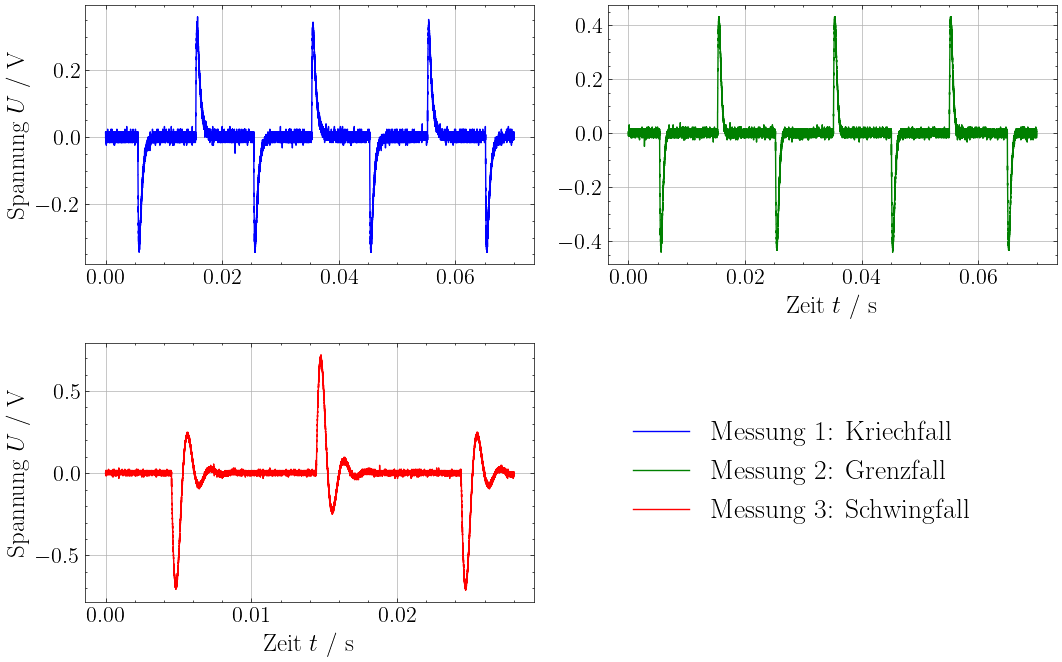

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2,2, figsize=(11, 7))

tilte = ['Kriechfall', 'Grenzfall', 'Schwingfall']
color = ['blue', 'green', 'red']
lines = []
for i,j in enumerate([2, 3, 4]):
    x,y = AXES[j]
    time, channels, units = extract_csv(files[j])
    l, = axs[x][y].plot(time, channels[0], color=color[i])
    l.set_label(f'Messung {i+1}: {tilte[i]}')
    axs[x][y].grid(True)
    lines.append(l)

axs[0][0].set_ylabel(r'Spannung $U$ / V', fontsize=18)
axs[1][0].set_ylabel(r'Spannung $U$ / V', fontsize=18)

axs[0][1].set_xlabel(r'Zeit $t$ / s', fontsize=18)
axs[1][0].set_xlabel(r'Zeit $t$ / s', fontsize=18)
#axs[0][0].set_xlabel(r'Zeit $t$ / s', fontsize=18)

axs[1][1].axis('off')
axs[1][1].legend(handles=lines, fontsize=20, loc='center left')
plt.tight_layout()



### gemeinsamer Plot

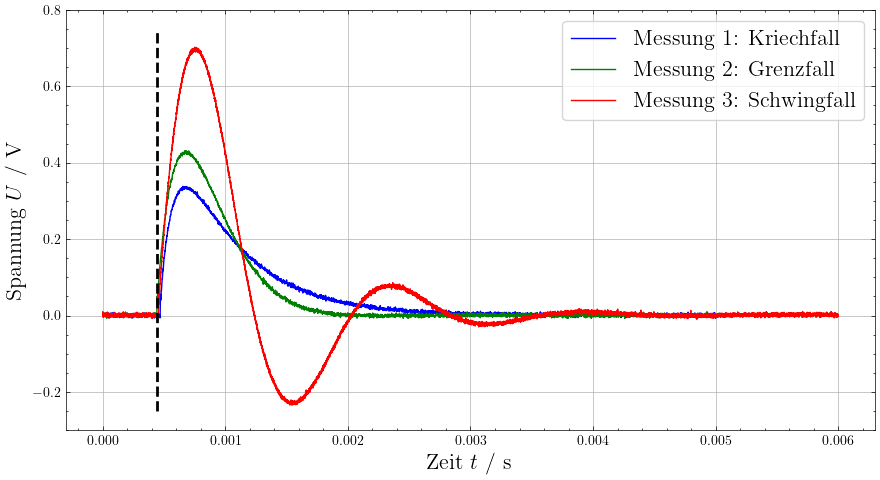

In [8]:
fig, ax = plt.subplots(1,1, figsize=(9, 5))
tilte = ['Kriechfall', 'Grenzfall', 'Schwingfall']
color = ['blue', 'green', 'red']

t0 = [0.015, 0.01485, 0.014]

for i,j in enumerate([2, 3, 4]):
    x,y = AXES[j]
    time, channels, units = extract_csv(files[j])
    mask = np.logical_and(time>t0[i], time<0.02)

    y = channels[0][mask]
    wl = 11 if len(y) >= 11 else (len(y) // 2 * 2 + 1)
    if wl >= 3:
        y_smooth = savgol_filter(y, window_length=wl, polyorder=3)
    else:
        y_smooth = y.copy()
    l, = ax.plot(time[mask]-t0[i], y_smooth, color=color[i])
    l.set_label(f'Messung {i+1}: {tilte[i]}')

ax.grid(True)
ax.set_ylabel(r'Spannung $U$ / V', fontsize=16)
ax.set_xlabel(r'Zeit $t$ / s', fontsize=16)
ax.vlines(0.00044,-0.25,0.75, colors='black', linewidth=2, linestyles='--')
ax.legend(frameon=True, fontsize=16)

plt.tight_layout()

In [22]:
def dRmess(val):
    return val * 0.009 + 0.2

Ind = lambda R,C : 0.25*C*R**2

R_mit = np.array([346.1, 331.5, 349.4, 339.0])
R_ohne = np.array([119.0, 124.1, 119.5, 122.2])

C = 1e-6
dC = 0.01*C

R = np.mean(R_ohne)
dR = 0.6*np.std(R_ohne)

L = Ind(R, C)*1000
dL = L*(2*dR / R + dC / C)
print(L,dL)

3.67236 0.11198967825574539


## Versuch 3 Piezo

### Messsignal

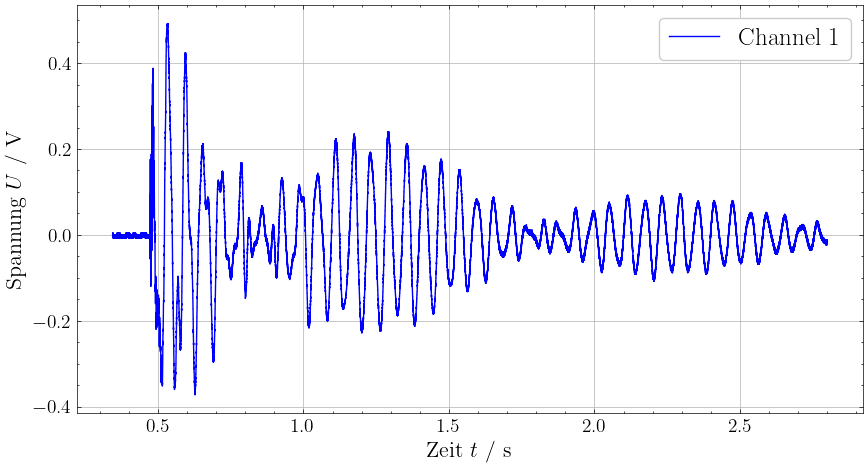

In [ ]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(9, 5))
time, channels, units = extract_csv(files[5])
color = ['blue', 'red']
for j in range(len(channels)):
    plt.plot(time, channels[j], label=f'Channel {j+1}', color=color[j])
plt.xlabel(r'Zeit $t$ / s', fontsize=16)
plt.ylabel(r'Spannung $U$ / V', fontsize=16)
plt.legend(loc='best',framealpha=1, facecolor='white',frameon=True, fontsize=18)
plt.grid(True)
plt.tight_layout()

### Periodendauer

Detected 8 peaks, giving 7 periods.
Mean period = 0.060583 s
Std (sample) = 0.001382 s
16.506319562346725 0.37655318836611446


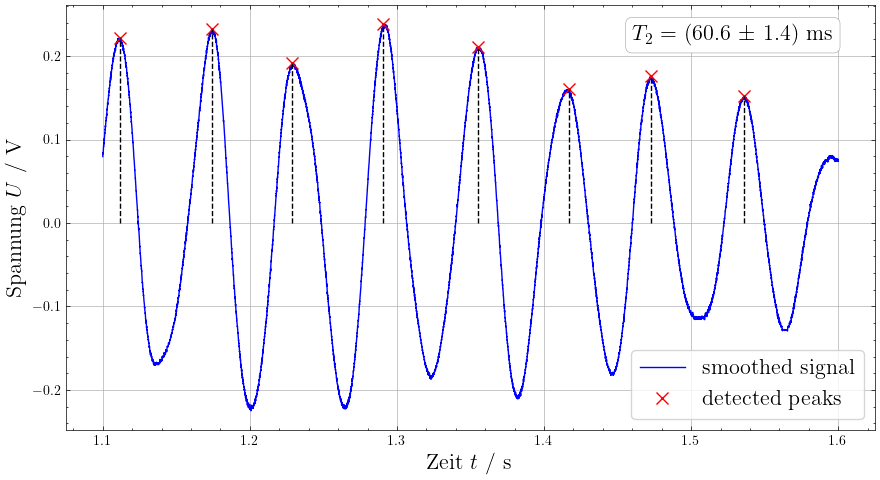

In [6]:
time, channels, units = extract_csv(files[5])
mask = np.logical_and(time > 1.1, time < 1.6)
t = time[mask]
y = channels[0][mask]

USE_SMOOTHING = True
if USE_SMOOTHING:
    # window_length must be odd and <= len(y); adjust if necessary
    wl = 11 if len(y) >= 11 else (len(y) // 2 * 2 + 1)
    if wl >= 3:
        y_smooth = savgol_filter(y, window_length=wl, polyorder=3)
    else:
        y_smooth = y.copy()
else:
    y_smooth = y.copy()


# find peaks and clculate Period
peaks, props = find_peaks(y_smooth, prominence=0.05, distance=200)
peak_times = t[peaks]
periods = np.diff(peak_times) 

if len(periods) == 0:
    print("No periods found: adjust peak detection parameters (prominence/distance/threshold) or smoothing.")
else:
    mean_period = np.mean(periods)
    std_period = np.std(periods)/np.sqrt(len(periods))
   
    print(f"Detected {len(peaks)} peaks, giving {len(periods)} periods.")
    print(f"Mean period = {mean_period:.6f} s")
    print(f"Std (sample) = {std_period:.6f} s")
    print(1/mean_period, std_period/(mean_period**2))

    # --- plots ---
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    # ax.plot(t, y, label='raw signal')
    if USE_SMOOTHING:
        ax.plot(t, y_smooth, label='smoothed signal', linewidth=1, color='blue')
    ax.plot(peak_times, (y_smooth[peaks]), 'x', markersize=8, label='detected peaks', color='red')
    ax.vlines(peak_times, 0, (y_smooth[peaks]), color='black', linestyles='--')
    ax.set_xlabel(r'Zeit $t$ / s', fontsize=16)
    ax.set_ylabel(r'Spannung $U$ / V', fontsize=16)
    ax.grid(True)
    ax.legend(loc='lower right', frameon=True, fontsize=16)

    # annotate mean period on plot
    if len(periods) > 0:
        ax.annotate(rf"$T_2$ = ({mean_period*1000:.1f} $\pm$ {std_period*1000:.1f}) ms",
                     xy=(0.7, 0.955), xycoords='axes fraction', va='top', fontsize=16,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=(0, 0, 0, 0.3), lw=0.5))

    plt.tight_layout()